# Exoplanet Classification Project

This notebook analyzes NASA's exoplanet datasets from Kepler, K2, and TESS missions to build a machine learning model that can identify new exoplanets. We'll also develop a web interface to facilitate user interaction with the model.

## Project Overview

1. **Data Loading and Exploration**: Load and explore NASA's exoplanet datasets
2. **Data Cleaning and Preprocessing**: Handle missing values, outliers, and standardize data
3. **Feature Engineering**: Create derived features and select the most relevant ones
4. **Model Selection and Training**: Implement and compare multiple classification algorithms
5. **Model Evaluation**: Evaluate model performance using various metrics
6. **Web Interface Development**: Create a web application for user interaction
7. **Interactive Prediction System**: Implement functionality for users to input new data

Let's get started!

## 1. Import Required Libraries

First, we'll import all the necessary Python libraries for data manipulation, visualization, machine learning, and web interface development.

In [37]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


import streamlit as st


import os
import warnings
import pickle
from tqdm import tqdm


warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")


np.random.seed(42)


## 2. Data Loading and Exploration

Let's load the NASA exoplanet datasets from Kepler, K2, and TESS missions. We'll then explore their structure and understand the features.

In [ ]:



try:
    kepler_data = pd.read_csv(r'C:\Users\HP\Downloads\cumulative_2025.10.03_08.41.48.csv', comment='#')
    print(f"Kepler data loaded successfully with {kepler_data.shape[0]} rows and {kepler_data.shape[1]} columns")
except Exception as e:
    print(f"Error loading Kepler data: {e}")
    kepler_data = None


try:
    k2_data = pd.read_csv(r'C:\Users\HP\Downloads\k2pandc_2025.10.04_09.38.20.csv', comment='#')
    print(f"K2 data loaded successfully with {k2_data.shape[0]} rows and {k2_data.shape[1]} columns")
except Exception as e:
    print(f"Error loading K2 data: {e}")
    k2_data = None


try:
    toi_data = pd.read_csv(r'C:\Users\HP\Downloads\TOI_2025.10.04_09.37.51.csv', comment='#')
    print(f"TESS TOI data loaded successfully with {toi_data.shape[0]} rows and {toi_data.shape[1]} columns")
except Exception as e:
    print(f"Error loading TESS TOI data: {e}")
    toi_data = None

Kepler data loaded successfully with 9564 rows and 49 columns
K2 data loaded successfully with 4004 rows and 295 columns
TESS TOI data loaded successfully with 7703 rows and 87 columns


### 2.1 Exploring the Kepler Dataset

Let's first explore the Kepler Cumulative dataset to understand its structure, columns, and basic statistics.

In [12]:
if kepler_data is not None:

    print("First 5 rows of Kepler dataset:")
    display(kepler_data.head())


    print("\nKepler dataset info:")
    kepler_data.info()


    print("\nKepler dataset statistics:")
    display(kepler_data.describe())


    print("\nMissing values in Kepler dataset:")
    missing_values = kepler_data.isnull().sum()
    display(missing_values[missing_values > 0])


    if 'koi_disposition' in kepler_data.columns:
        print("\nDistribution of exoplanet dispositions (Kepler):")
        display(kepler_data['koi_disposition'].value_counts())
    elif 'koi_pdisposition' in kepler_data.columns:
        print("\nDistribution of exoplanet dispositions (Kepler):")
        display(kepler_data['koi_pdisposition'].value_counts())
    else:
        print("\nDisposition column not found in Kepler dataset.")

First 5 rows of Kepler dataset:


kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0           -81.0      4.467           0.064          -0.096     0.927   
1           -81.0      4.467           0.064          -0.096     0.927   
2          -176.0      4.544           0.044          -0.176     0.868   
3          -174.0      4.564           0.053          -0.168     0.791   
4          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 49 columns]


Kepler dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  ko

kepid    koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
count  9.564000e+03  8054.000000    9564.000000    9564.000000    9564.000000   
mean   7.690628e+06     0.480829       0.208595       0.232748       0.197512   
std    2.653459e+06     0.476928       4.767290       0.422605       0.398142   
min    7.574500e+05     0.000000       0.000000       0.000000       0.000000   
25%    5.556034e+06     0.000000       0.000000       0.000000       0.000000   
50%    7.906892e+06     0.334000       0.000000       0.000000       0.000000   
75%    9.873066e+06     0.998000       0.000000       0.000000       0.000000   
max    1.293514e+07     1.000000     465.000000       1.000000       1.000000   

       koi_fpflag_ec     koi_period  koi_period_err1  koi_period_err2  \
count    9564.000000    9564.000000      9110.000000      9110.000000   
mean        0.120033      75.671358         0.002148        -0.002148   
std         0.325018    1334.744046         0.008236         0.008236   
min         0.000000       0.241843         0.000000        -0.172500   
25%         0.000000       2.733684         0.000005        -0.000276   
50%         0.000000       9.752831         0.000035        -0.000035   
75%         0.000000      40.715178         0.000276        -0.000005   
max         1.000000  129995.778400         0.172500         0.000000   

       koi_time0bk  ...  koi_steff_err2    koi_slogg  koi_slogg_err1  \
count  9564.000000  ...     9081.000000  9201.000000     9096.000000   
mean    166.183251  ...     -162.265059     4.310157        0.120738   
std      67.918960  ...       72.746348     0.432606        0.132837   
min     120.515914  ...    -1762.000000     0.047000        0.000000   
25%     132.761718  ...     -198.000000     4.218000        0.042000   
50%     137.224595  ...     -160.000000     4.438000        0.070000   
75%     170.694603  ...     -114.000000     4.543000        0.149000   
max    1472.522306  ...        0.000000     5.364000        1.472000   

       koi_slogg_err2     koi_srad  koi_srad_err1  koi_srad_err2           ra  \
count     9096.000000  9201.000000    9096.000000    9096.000000  9564.000000   
mean        -0.143161     1.728712       0.362292      -0.394806   292.060163   
std          0.085477     6.127185       0.930870       2.168213     4.766657   
min         -1.207000     0.109000       0.000000    -116.137000   279.852720   
25%         -0.196000     0.829000       0.129000      -0.250000   288.660770   
50%         -0.128000     1.000000       0.251000      -0.111000   292.261125   
75%         -0.088000     1.345000       0.364000      -0.069000   295.859160   
max          0.000000   229.908000      33.091000       0.000000   301.720760   

               dec   koi_kepmag  
count  9564.000000  9563.000000  
mean     43.810433    14.264606  
std       3.601243     1.385448  
min      36.577381     6.966000  
25%      40.777173    13.440000  
50%      43.677504    14.520000  
75%      46.714611    15.322000  
max      52.336010    20.003000  

[8 rows x 44 columns]


Missing values in Kepler dataset:


kepler_name          6817
koi_score            1510
koi_period_err1       454
koi_period_err2       454
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_err1        468
koi_steff_err2        483
koi_slogg             363
koi_slogg_err1        468
koi_slogg_err2        468
koi_srad              363
koi_srad_err1         468
koi_srad_err2         468
koi_kepmag              1
dtype: int64


Distribution of exoplanet dispositions (Kepler):


koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

### 2.2 Exploring the K2 Dataset

Now let's explore the K2 dataset, which contains data from the K2 mission (the second phase of the Kepler mission).

In [14]:
if k2_data is not None:

    print("First 5 rows of K2 dataset:")
    display(k2_data.head())


    print("\nK2 dataset info:")
    k2_data.info()


    print("\nK2 dataset statistics:")
    display(k2_data.describe())


    print("\nMissing values in K2 dataset:")
    missing_values = k2_data.isnull().sum()
    display(missing_values[missing_values > 0])


    if 'disposition' in k2_data.columns:
        print("\nDistribution of exoplanet dispositions (K2):")
        display(k2_data['disposition'].value_counts())


First 5 rows of K2 dataset:


rowid            pl_name        hostname pl_letter  k2_name  \
0      1        BD+20 594 b       BD+20 594         b  K2-56 b   
1      2        BD+20 594 b       BD+20 594         b  K2-56 b   
2      3        BD+20 594 b       BD+20 594         b  K2-56 b   
3      4  EPIC 201111557.01  EPIC 201111557       NaN      NaN   
4      5  EPIC 201111557.01  EPIC 201111557       NaN      NaN   

    epic_hostname      epic_candname hd_name hip_name         tic_id  ...  \
0  EPIC 210848071  EPIC 210848071.01     NaN      NaN   TIC 26123781  ...   
1  EPIC 210848071  EPIC 210848071.01     NaN      NaN   TIC 26123781  ...   
2  EPIC 210848071  EPIC 210848071.01     NaN      NaN   TIC 26123781  ...   
3  EPIC 201111557  EPIC 201111557.01     NaN      NaN  TIC 176942156  ...   
4  EPIC 201111557  EPIC 201111557.01     NaN      NaN  TIC 176942156  ...   

  releasedate  pl_nnotes k2_campaigns k2_campaigns_num  st_nphot  st_nrvc  \
0  2018-02-15        1.0            4              1.0       0.0      0.0   
1  2016-07-28        1.0            4              1.0       0.0      0.0   
2  2018-04-26        1.0            4              1.0       0.0      0.0   
3  2018-08-02        0.0           10              1.0       0.0      0.0   
4  2018-02-15        0.0           10              1.0       0.0      0.0   

   st_nspec  pl_nespec pl_ntranspec  pl_ndispec  
0       0.0        0.0          0.0         0.0  
1       0.0        0.0          0.0         0.0  
2       0.0        0.0          0.0         0.0  
3       0.0        0.0          0.0         0.0  
4       0.0        0.0          0.0         0.0  

[5 rows x 295 columns]


K2 dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Columns: 295 entries, rowid to pl_ndispec
dtypes: float64(260), int64(2), object(33)
memory usage: 9.0+ MB

K2 dataset statistics:


rowid  default_flag      sy_snum      sy_pnum  sy_mnum  cb_flag  \
count  4004.000000   4004.000000  3987.000000  3987.000000   3987.0   3987.0   
mean   2002.500000      0.451049     1.051417     1.126912      0.0      0.0   
std    1155.999567      0.497660     0.252662     1.383526      0.0      0.0   
min       1.000000      0.000000     1.000000     0.000000      0.0      0.0   
25%    1001.750000      0.000000     1.000000     0.000000      0.0      0.0   
50%    2002.500000      0.000000     1.000000     1.000000      0.0      0.0   
75%    3003.250000      1.000000     1.000000     2.000000      0.0      0.0   
max    4004.000000      1.000000     3.000000     7.000000      0.0      0.0   

         disc_year      rv_flag  pul_flag  ptv_flag  ...  sy_kepmagerr1  \
count  3987.000000  3987.000000    3987.0    3987.0  ...            0.0   
mean   2017.553800     0.241284       0.0       0.0  ...            NaN   
std       2.033168     0.427916       0.0       0.0  ...            NaN   
min    2011.000000     0.000000       0.0       0.0  ...            NaN   
25%    2016.000000     0.000000       0.0       0.0  ...            NaN   
50%    2018.000000     0.000000       0.0       0.0  ...            NaN   
75%    2018.500000     0.000000       0.0       0.0  ...            NaN   
max    2025.000000     1.000000       0.0       0.0  ...            NaN   

       sy_kepmagerr2    pl_nnotes  k2_campaigns_num     st_nphot      st_nrvc  \
count            0.0  3981.000000       3977.000000  3981.000000  3981.000000   
mean             NaN     0.405426          1.306512     0.033911     0.005777   
std              NaN     0.826332          0.574737     0.181023     0.075799   
min              NaN     0.000000          1.000000     0.000000     0.000000   
25%              NaN     0.000000          1.000000     0.000000     0.000000   
50%              NaN     0.000000          1.000000     0.000000     0.000000   
75%              NaN     1.000000          1.000000     0.000000     0.000000   
max              NaN     6.000000          3.000000     1.000000     1.000000   

       st_nspec    pl_nespec  pl_ntranspec  pl_ndispec  
count    3981.0  3981.000000   3981.000000      3981.0  
mean        0.0     0.006280      0.144185         0.0  
std         0.0     0.103752      1.069123         0.0  
min         0.0     0.000000      0.000000         0.0  
25%         0.0     0.000000      0.000000         0.0  
50%         0.0     0.000000      0.000000         0.0  
75%         0.0     0.000000      0.000000         0.0  
max         0.0     2.000000     17.000000         0.0  

[8 rows x 262 columns]


Missing values in K2 dataset:


pl_letter        1682
k2_name          1699
epic_hostname       2
epic_candname     342
hd_name          3897
                 ... 
st_nrvc            23
st_nspec           23
pl_nespec          23
pl_ntranspec       23
pl_ndispec         23
Length: 289, dtype: int64


Distribution of exoplanet dispositions (K2):


disposition
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

### 2.3 Exploring the TESS TOI Dataset

Finally, let's explore the TESS Objects of Interest (TOI) dataset, which contains data from the TESS mission.

In [15]:
if toi_data is not None:

    print("First 5 rows of TESS TOI dataset:")
    display(toi_data.head())


    print("\nTESS TOI dataset info:")
    toi_data.info()


    print("\nTESS TOI dataset statistics:")
    display(toi_data.describe())


    print("\nMissing values in TESS TOI dataset:")
    missing_values = toi_data.isnull().sum()
    display(missing_values[missing_values > 0])


    if 'tfopwg_disp' in toi_data.columns:
        print("\nDistribution of exoplanet dispositions (TESS TOI):")
        display(toi_data['tfopwg_disp'].value_counts())
    else:
        print("\nDisposition column not found in TESS TOI dataset.")

First 5 rows of TESS TOI dataset:


rowid      toi  toipfx        tid    ctoi_alias  pl_pnum tfopwg_disp  \
0      1  1000.01    1000   50365310  5.036531e+07        1          FP   
1      2  1001.01    1001   88863718  8.886372e+07        1          PC   
2      3  1002.01    1002  124709665  1.247097e+08        1          FP   
3      4  1003.01    1003  106997505  1.069975e+08        1          FP   
4      5  1004.01    1004  238597883  2.385979e+08        1          FP   

          rastr          ra  raerr1  ...  st_loggerr2 st_logglim  \
0  07h29m25.85s  112.357708     NaN  ...        -0.07          0   
1  08h10m19.31s  122.580465     NaN  ...        -0.09          0   
2  06h58m54.47s  104.726966     NaN  ...          NaN          0   
3  07h22m14.39s  110.559945     NaN  ...        -1.64          0   
4  08h08m42.77s  122.178195     NaN  ...        -0.07          0   

   st_loggsymerr   st_rad  st_raderr1  st_raderr2  st_radlim  st_radsymerr  \
0              1  2.16986    0.072573   -0.072573          0             1   
1              1  2.01000    0.090000   -0.090000          0             1   
2              1  5.73000         NaN         NaN          0             1   
3              1      NaN         NaN         NaN          0             1   
4              1  2.15000    0.060000   -0.060000          0             1   

           toi_created            rowupdate  
0  2019-07-24 15:58:33  2024-09-09 10:08:01  
1  2019-07-24 15:58:33  2023-04-03 14:31:04  
2  2019-07-24 15:58:33  2022-07-11 16:02:02  
3  2019-07-24 15:58:33  2022-02-23 10:10:02  
4  2019-07-24 15:58:33  2024-09-09 10:08:01  

[5 rows x 87 columns]


TESS TOI dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 87 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              7703 non-null   int64  
 1   toi                7703 non-null   float64
 2   toipfx             7703 non-null   int64  
 3   tid                7703 non-null   int64  
 4   ctoi_alias         7703 non-null   float64
 5   pl_pnum            7703 non-null   int64  
 6   tfopwg_disp        7703 non-null   object 
 7   rastr              7703 non-null   object 
 8   ra                 7703 non-null   float64
 9   raerr1             0 non-null      float64
 10  raerr2             0 non-null      float64
 11  decstr             7703 non-null   object 
 12  dec                7703 non-null   float64
 13  decerr1            0 non-null      float64
 14  decerr2            0 non-null      float64
 15  st_pmra            7569 non-null   float64
 16  

rowid          toi       toipfx           tid    ctoi_alias  \
count  7703.000000  7703.000000  7703.000000  7.703000e+03  7.703000e+03   
mean   3852.000000  3749.039313  3749.028820  2.455227e+08  2.455227e+08   
std    2223.808895  2152.357244  2152.357601  1.616968e+08  1.616968e+08   
min       1.000000   101.010000   101.000000  2.876000e+03  2.876010e+03   
25%    1926.500000  1861.510000  1861.500000  1.311389e+08  1.311389e+08   
50%    3852.000000  3736.010000  3736.000000  2.499452e+08  2.499452e+08   
75%    5777.500000  5615.510000  5615.500000  3.540917e+08  3.540917e+08   
max    7703.000000  7509.010000  7509.000000  2.041563e+09  2.041563e+09   

           pl_pnum           ra  raerr1  raerr2          dec  ...  \
count  7703.000000  7703.000000     0.0     0.0  7703.000000  ...   
mean      1.049331   179.804241     NaN     NaN     1.156538  ...   
std       0.273293   103.705905     NaN     NaN    47.465287  ...   
min       1.000000     0.084680     NaN     NaN   -89.471513  ...   
25%       1.000000    96.069552     NaN     NaN   -43.355251  ...   
50%       1.000000   161.156925     NaN     NaN     4.715116  ...   
75%       1.000000   283.061467     NaN     NaN    43.806822  ...   
max       5.000000   359.941195     NaN     NaN    89.086923  ...   

           st_logg  st_loggerr1  st_loggerr2  st_logglim  st_loggsymerr  \
count  6847.000000  5432.000000  5432.000000      7703.0         7703.0   
mean      4.305269     0.174805    -0.174805         0.0            1.0   
std       0.304492     0.351881     0.351881         0.0            0.0   
min       0.100000     0.000391    -2.010840         0.0            1.0   
25%       4.123720     0.080000    -0.092600         0.0            1.0   
50%       4.330000     0.084561    -0.084561         0.0            1.0   
75%       4.500000     0.092600    -0.080000         0.0            1.0   
max       5.960650     2.010840    -0.000391         0.0            1.0   

            st_rad   st_raderr1   st_raderr2  st_radlim  st_radsymerr  
count  7196.000000  5740.000000  5740.000000     7703.0        7703.0  
mean      1.403747     0.074439    -0.074439        0.0           1.0  
std       1.598079     0.082037     0.082037        0.0           0.0  
min       0.114827     0.003357    -1.723020        0.0           1.0  
25%       0.890000     0.050000    -0.080000        0.0           1.0  
50%       1.234340     0.060000    -0.060000        0.0           1.0  
75%       1.660000     0.080000    -0.050000        0.0           1.0  
max     102.030000     1.723020    -0.003357        0.0           1.0  

[8 rows x 82 columns]


Missing values in TESS TOI dataset:


raerr1             7703
raerr2             7703
decerr1            7703
decerr2            7703
st_pmra             134
st_pmraerr1         134
st_pmraerr2         134
st_pmralim          134
st_pmrasymerr       134
st_pmdec            134
st_pmdecerr1        134
st_pmdecerr2        134
st_pmdeclim         134
st_pmdecsymerr      134
pl_tranmiderr1       11
pl_tranmiderr2       11
pl_orbper           107
pl_orbpererr1       131
pl_orbpererr2       131
pl_trandurherr1      13
pl_trandurherr2      13
pl_trandeperr1        6
pl_trandeperr2        6
pl_rade             506
pl_radeerr1        1623
pl_radeerr2        1623
pl_insol            176
pl_insolerr1       7703
pl_insolerr2       7703
pl_insollim        7703
pl_insolsymerr     7703
pl_eqt              311
pl_eqterr1         7703
pl_eqterr2         7703
pl_eqtlim          7703
pl_eqtsymerr       7703
st_dist             215
st_disterr1         707
st_disterr2         707
st_teff             161
st_tefferr1         474
st_tefferr2     


Distribution of exoplanet dispositions (TESS TOI):


tfopwg_disp
PC     4679
FP     1197
CP      684
KP      583
APC     462
FA       98
Name: count, dtype: int64

### 2.4 Data Visualization

Let's create some visualizations to better understand the data distribution and relationships between features.

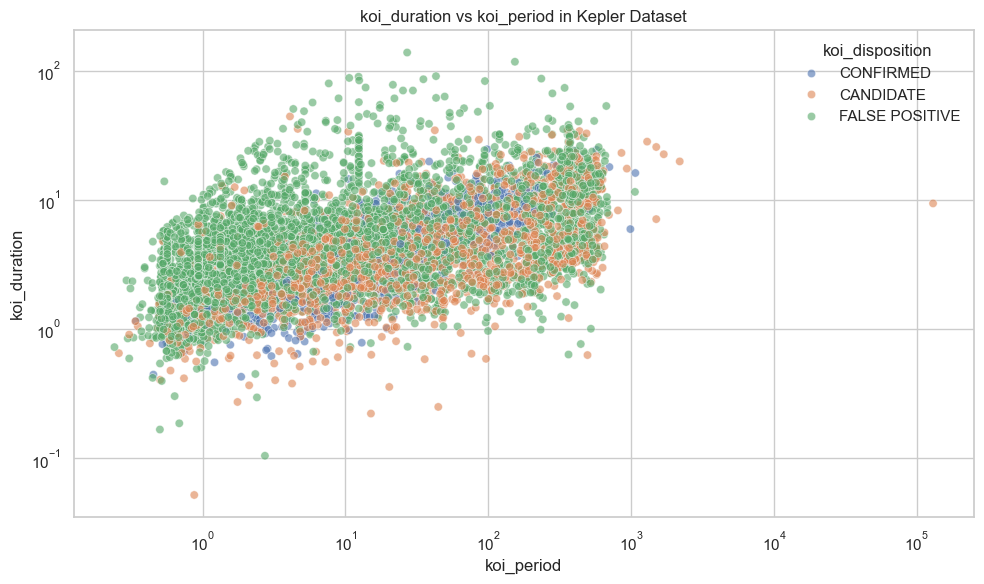

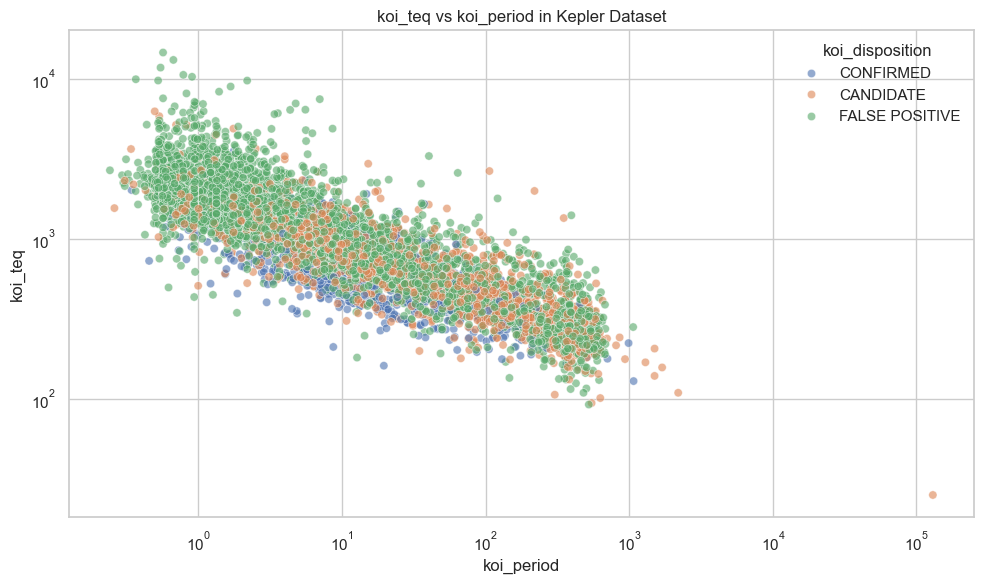

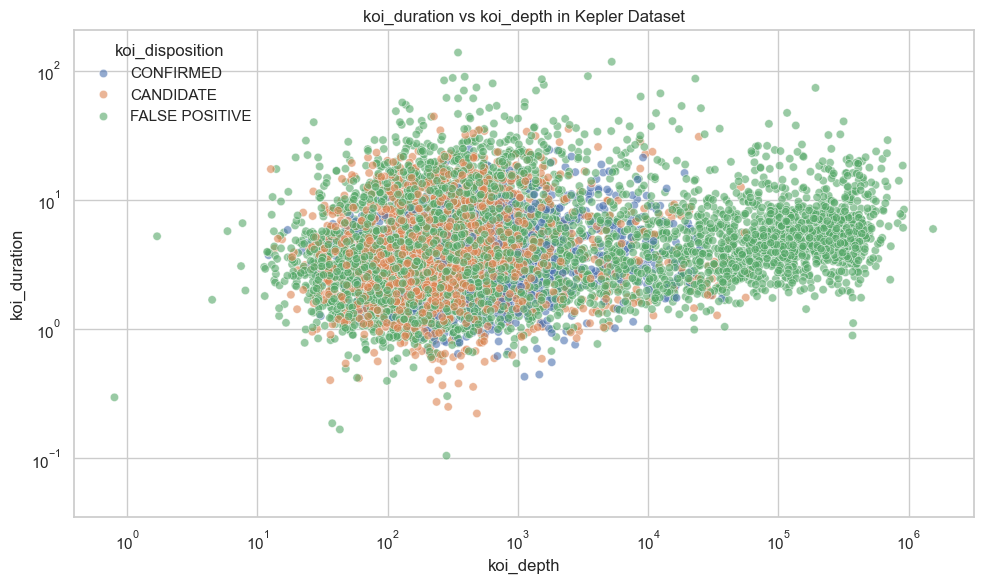

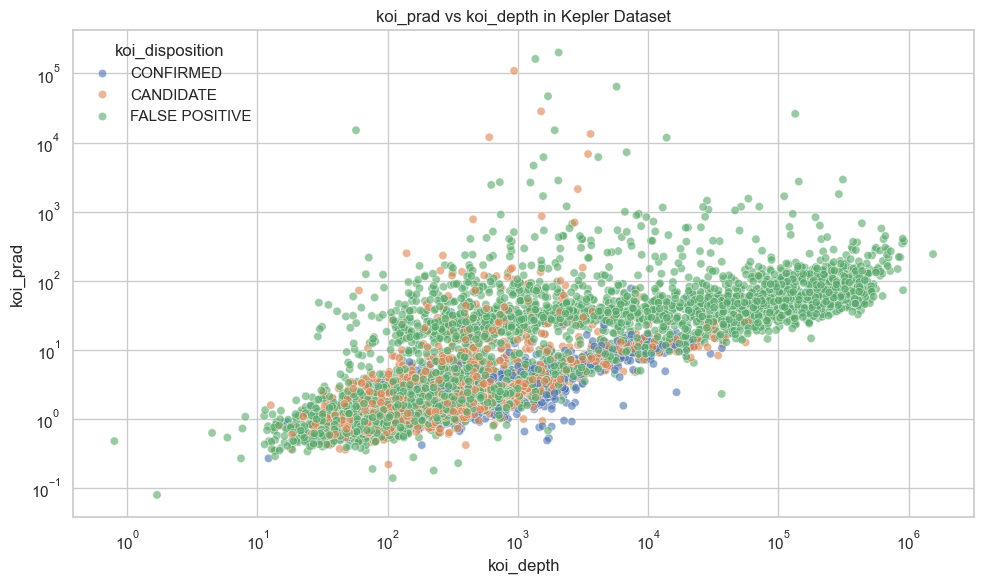

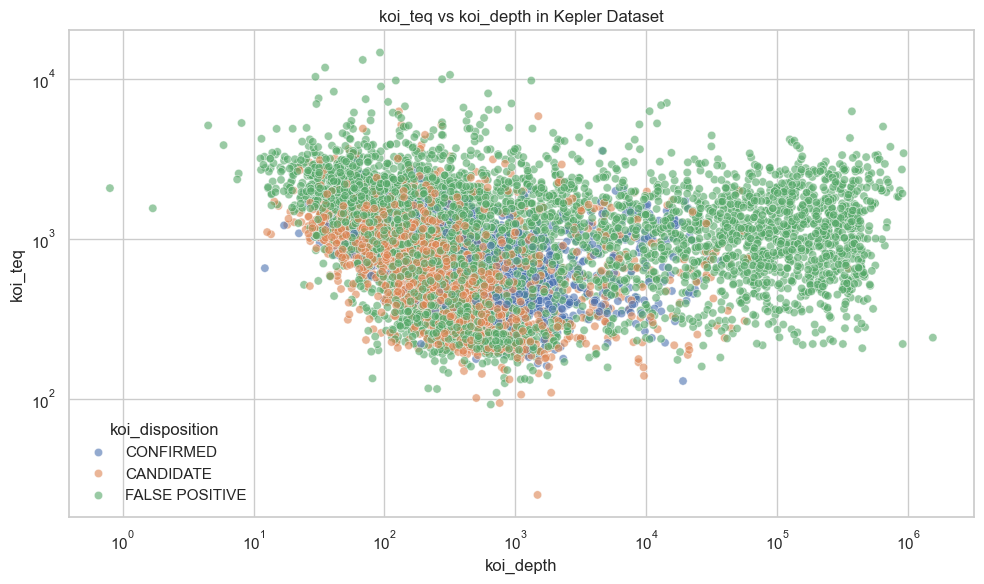

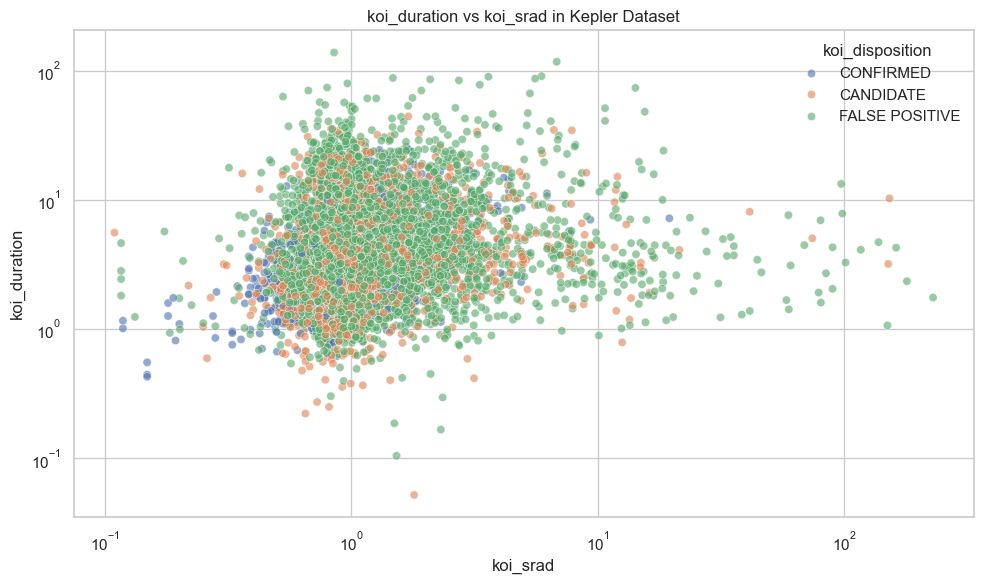

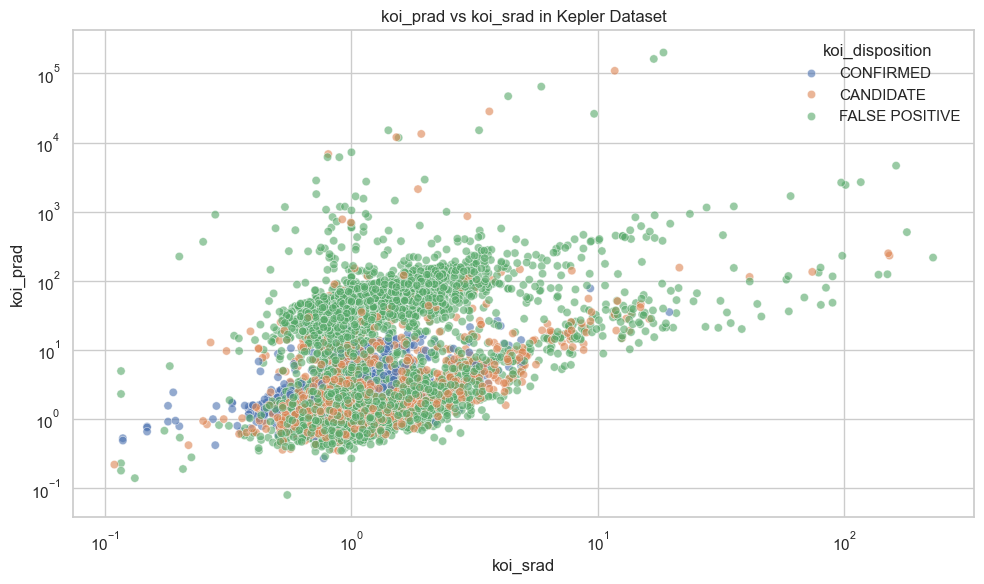

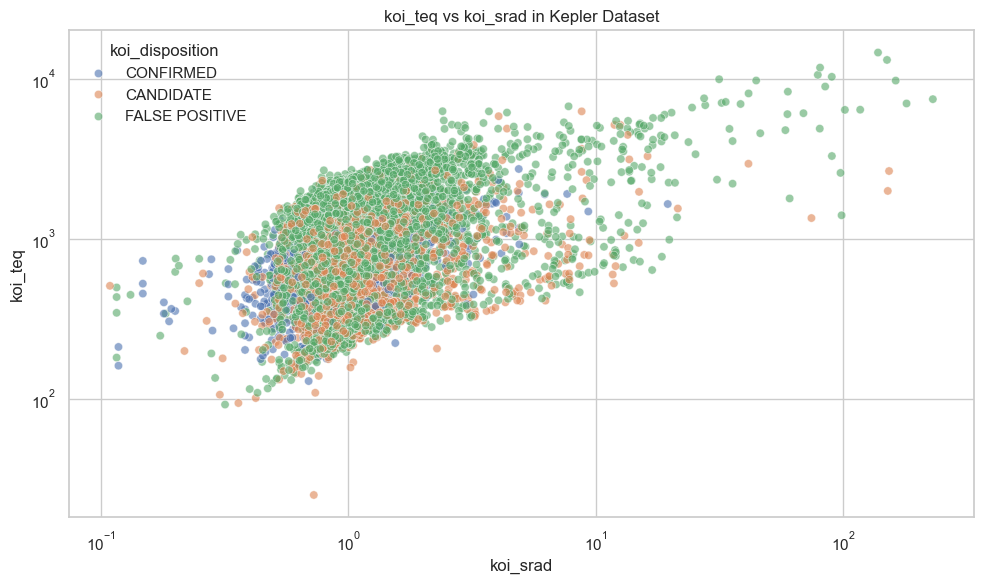

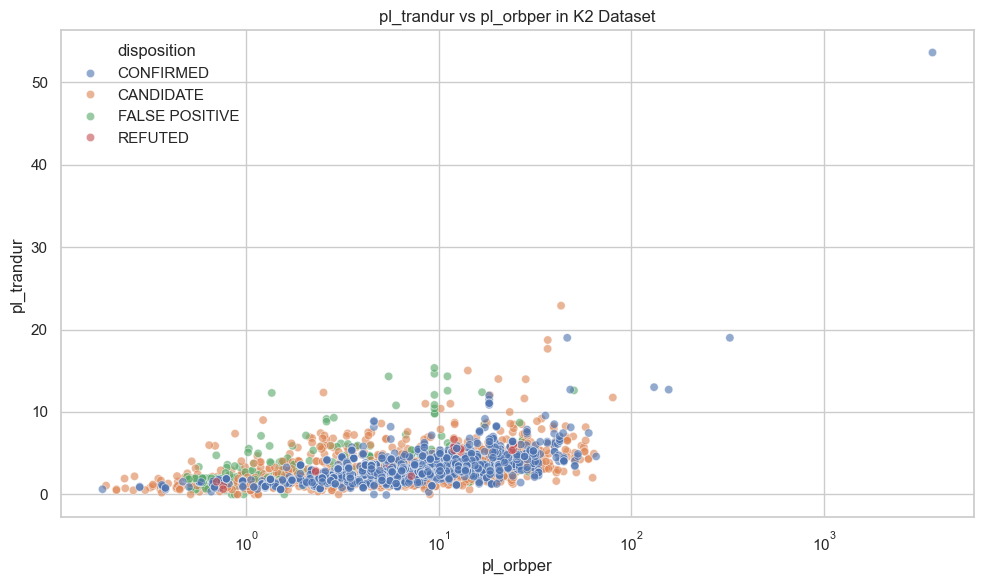

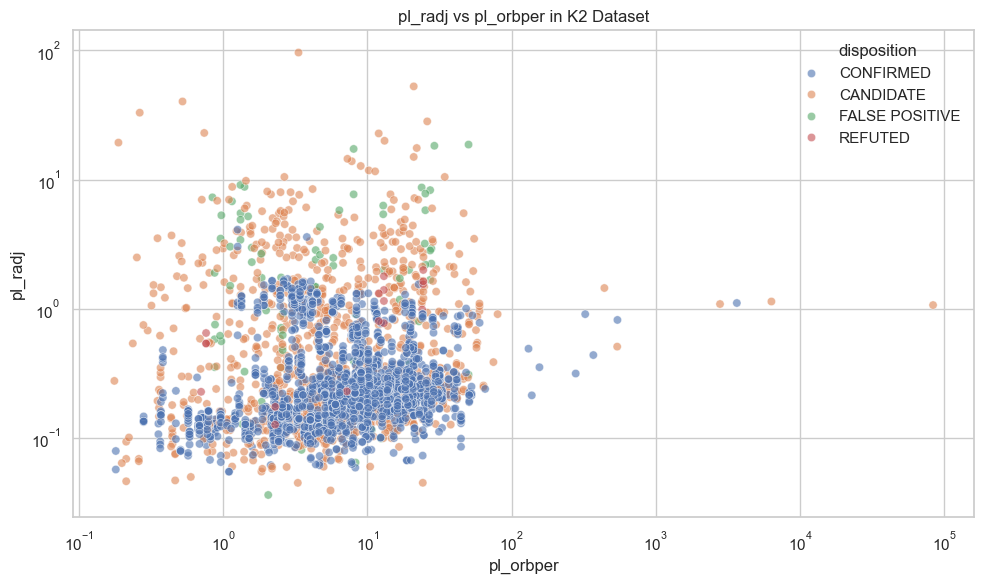

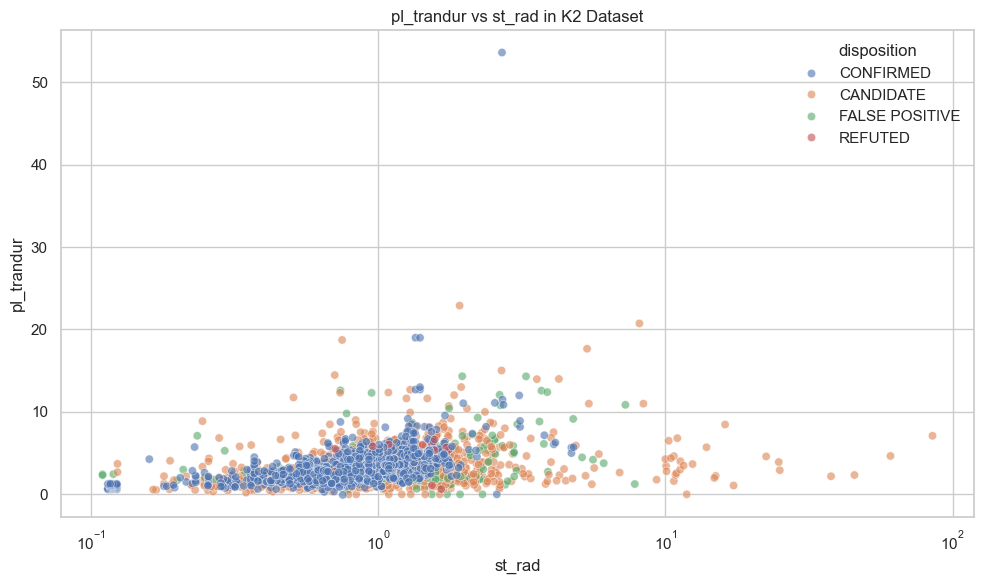

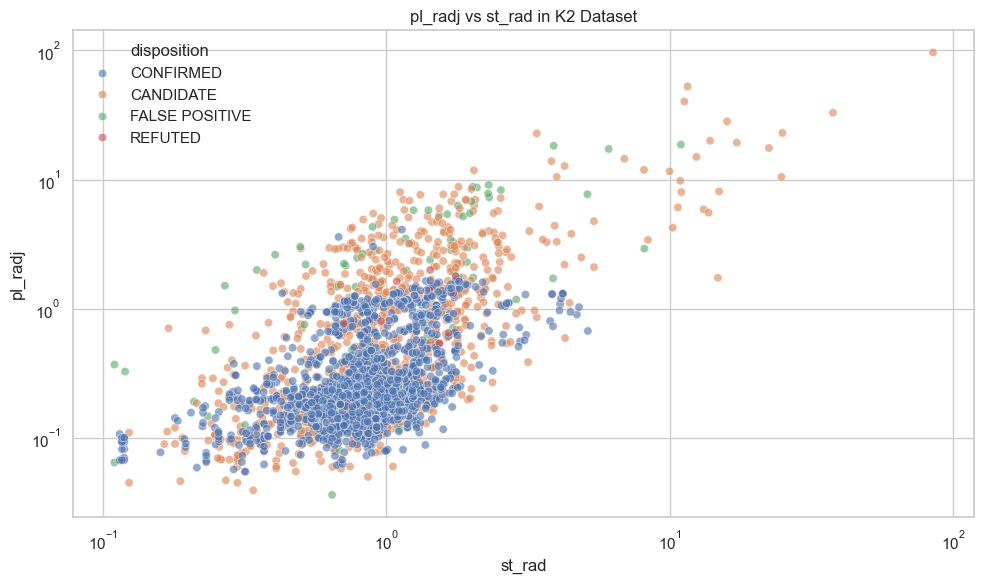

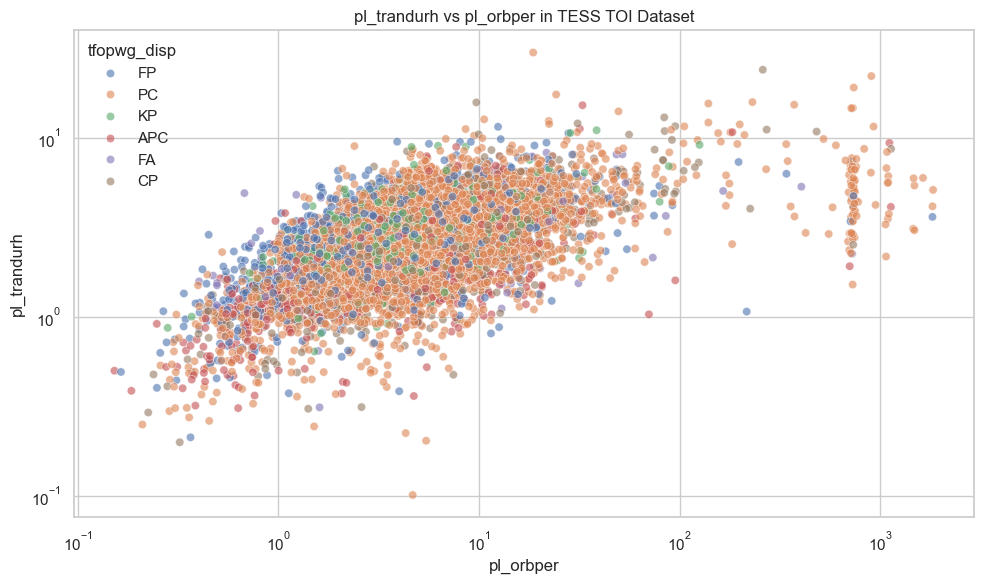

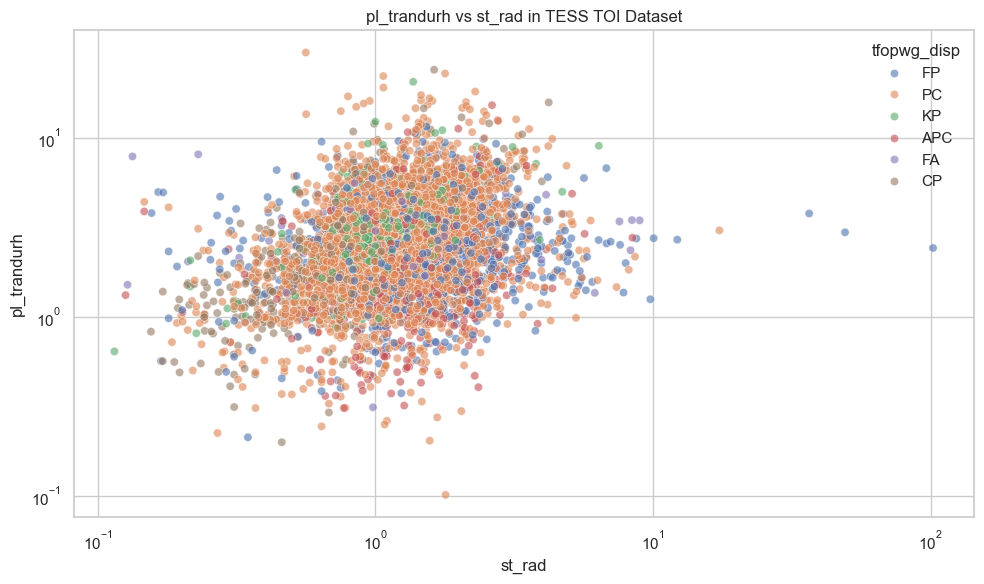

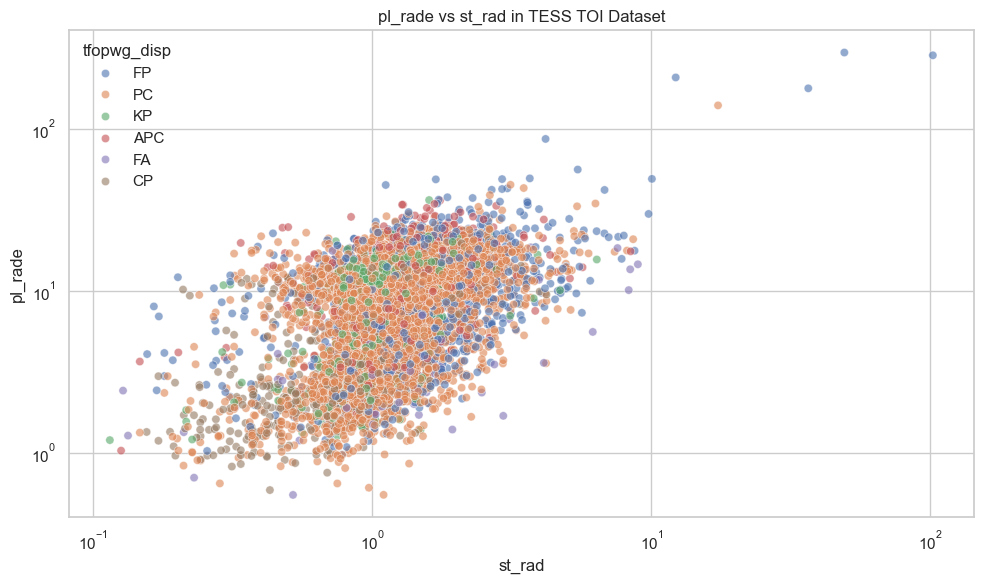

In [42]:

def create_feature_relationship_plots(data, dataset_name, x_features, y_features, class_column=None):
    if data is None:
        print(f"No data available for {dataset_name}")
        return


    valid_x = [col for col in x_features if col in data.columns and pd.api.types.is_numeric_dtype(data[col])]
    valid_y = [col for col in y_features if col in data.columns and pd.api.types.is_numeric_dtype(data[col])]

    if not valid_x or not valid_y:
        print(f"No valid numeric features found for scatter plots in {dataset_name} dataset")
        return


    for x_col in valid_x:
        for y_col in valid_y:
            if x_col != y_col:
                plt.figure(figsize=(10, 6))

                if class_column and class_column in data.columns:

                    scatter = sns.scatterplot(
                        data=data,
                        x=x_col,
                        y=y_col,
                        hue=class_column,
                        alpha=0.6
                    )
                else:

                    scatter = sns.scatterplot(
                        data=data,
                        x=x_col,
                        y=y_col,
                        alpha=0.6
                    )

                plt.title(f'{y_col} vs {x_col} in {dataset_name} Dataset')


                if data[x_col].max() / (data[x_col].min() + 1e-10) > 100:
                    plt.xscale('log')
                if data[y_col].max() / (data[y_col].min() + 1e-10) > 100:
                    plt.yscale('log')

                plt.tight_layout()
                plt.show()


kepler_x_features = ['koi_period', 'koi_depth', 'koi_srad']
kepler_y_features = ['koi_duration', 'koi_prad', 'koi_teq']

k2_x_features = ['pl_orbper', 'st_rad']
k2_y_features = ['pl_trandur', 'pl_radj']

toi_x_features = ['pl_orbper', 'st_rad']
toi_y_features = ['pl_trandurh', 'pl_rade']


if kepler_data is not None:
    class_column = 'koi_disposition' if 'koi_disposition' in kepler_data.columns else None
    create_feature_relationship_plots(kepler_data, 'Kepler', kepler_x_features, kepler_y_features, class_column)

if k2_data is not None:
    class_column = 'disposition' if 'disposition' in k2_data.columns else None
    create_feature_relationship_plots(k2_data, 'K2', k2_x_features, k2_y_features, class_column)

if toi_data is not None:
    class_column = 'tfopwg_disp' if 'tfopwg_disp' in toi_data.columns else None
    create_feature_relationship_plots(toi_data, 'TESS TOI', toi_x_features, toi_y_features, class_column)

## 3. Data Cleaning and Preprocessing

Now that we've explored the datasets, let's clean and preprocess them to prepare for machine learning. This includes handling missing values, standardizing column names, removing duplicates, and creating a unified dataset.

In [26]:

def clean_dataset(data, dataset_name, disposition_col=None):
    """
    Clean and preprocess a dataset by handling missing values, standardizing column names,
    and creating a target variable.

    Parameters:
    - data: DataFrame containing the data
    - dataset_name: Name of the dataset for logging purposes
    - disposition_col: Column name for exoplanet disposition/classification

    Returns:
    - Cleaned DataFrame
    """
    if data is None:
        print(f"No data available for {dataset_name}")
        return None

    print(f"Cleaning {dataset_name} dataset...")


    df = data.copy()


    initial_rows = len(df)
    df.dropna(how='all', inplace=True)
    print(f"Dropped {initial_rows - len(df)} rows with all NaN values")


    if dataset_name == 'Kepler':

        key_columns = [
            'kepid', 'kepoi_name', 'koi_disposition', 'koi_pdisposition',
            'koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
            'koi_teq', 'koi_insol', 'koi_srad', 'koi_sma', 'koi_impact'
        ]


        key_columns = [col for col in key_columns if col in df.columns]


        essential_cols = [col for col in ['kepoi_name', 'koi_disposition', 'koi_period', 'koi_duration', 'koi_depth']
                         if col in df.columns]

    elif dataset_name == 'K2':

        key_columns = [
            'epic_number', 'epic_candname', 'k2c_disp', 'pl_orbper',
            'pl_trandur', 'pl_radj', 'pl_eqt', 'pl_insol', 'st_rad'
        ]


        key_columns = [col for col in key_columns if col in df.columns]


        essential_cols = [col for col in ['epic_candname', 'k2c_disp', 'pl_orbper', 'pl_trandur']
                         if col in df.columns]

    elif dataset_name == 'TESS':

        key_columns = [
            'tid', 'toi', 'tfopwg_disp', 'pl_orbper',
            'pl_trandurh', 'pl_trandep', 'pl_rade',
            'pl_eqt', 'pl_insol', 'st_rad'
        ]


        key_columns = [col for col in key_columns if col in df.columns]


        essential_cols = [col for col in ['toi', 'tfopwg_disp', 'pl_orbper', 'pl_trandurh']
                         if col in df.columns]

    else:
        print(f"Unknown dataset name: {dataset_name}")
        return None


    if essential_cols:
        initial_rows = len(df)
        df.dropna(subset=essential_cols, inplace=True)
        print(f"Dropped {initial_rows - len(df)} rows with missing values in essential columns")


    for col in key_columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            if df[col].isnull().sum() > 0:
                median_value = df[col].median()
                df[col].fillna(median_value, inplace=True)
                print(f"Filled {df[col].isnull().sum()} missing values in {col} with median: {median_value:.4f}")


    if disposition_col and disposition_col in df.columns:

        if dataset_name == 'Kepler':

            df['exoplanet_class'] = df[disposition_col].apply(lambda x:
                                         'CONFIRMED' if x == 'CONFIRMED' else
                                         'CANDIDATE' if x == 'CANDIDATE' else
                                         'FALSE POSITIVE' if x == 'FALSE POSITIVE' else 'UNKNOWN')
        elif dataset_name == 'K2':

            df['exoplanet_class'] = df[disposition_col].apply(lambda x:
                                         'CONFIRMED' if x in ['CONFIRMED', 'C'] else
                                         'CANDIDATE' if x in ['CANDIDATE', 'PC'] else
                                         'FALSE POSITIVE' if x in ['FALSE POSITIVE', 'FP'] else 'UNKNOWN')
        elif dataset_name == 'TESS':

            df['exoplanet_class'] = df[disposition_col].apply(lambda x:
                                         'CONFIRMED' if x in ['CP', 'KP'] else
                                         'CANDIDATE' if x == 'PC' else
                                         'FALSE POSITIVE' if x == 'FP' else 'UNKNOWN')


        initial_rows = len(df)
        df = df[df['exoplanet_class'] != 'UNKNOWN']
        print(f"Removed {initial_rows - len(df)} rows with unknown exoplanet class")


        df['is_exoplanet'] = df['exoplanet_class'].apply(lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE'] else 0)

        print(f"Target variable distribution:")
        print(df['exoplanet_class'].value_counts())
        print(f"Binary target variable distribution:")
        print(df['is_exoplanet'].value_counts())


    df['source'] = dataset_name

    print(f"Cleaned {dataset_name} dataset has {len(df)} rows and {len(df.columns)} columns")
    return df


kepler_clean = None
k2_clean = None
toi_clean = None

if kepler_data is not None:

    kepler_disp_col = 'koi_disposition' if 'koi_disposition' in kepler_data.columns else 'koi_pdisposition'
    kepler_clean = clean_dataset(kepler_data, 'Kepler', kepler_disp_col)

if k2_data is not None:

    k2_disp_col = 'k2c_disp' if 'k2c_disp' in k2_data.columns else None
    k2_clean = clean_dataset(k2_data, 'K2', k2_disp_col)

if toi_data is not None:

    toi_disp_col = 'tfopwg_disp' if 'tfopwg_disp' in toi_data.columns else None
    toi_clean = clean_dataset(toi_data, 'TESS', toi_disp_col)

Cleaning Kepler dataset...
Dropped 0 rows with all NaN values
Dropped 363 rows with missing values in essential columns
Removed 0 rows with unknown exoplanet class
Target variable distribution:
exoplanet_class
FALSE POSITIVE    4582
CONFIRMED         2744
CANDIDATE         1875
Name: count, dtype: int64
Binary target variable distribution:
is_exoplanet
1    4619
0    4582
Name: count, dtype: int64
Cleaned Kepler dataset has 9201 rows and 52 columns
Cleaning K2 dataset...
Dropped 0 rows with all NaN values
Dropped 1443 rows with missing values in essential columns
Filled 0 missing values in pl_radj with median: 0.2470
Filled 0 missing values in pl_eqt with median: 884.5450
Filled 0 missing values in pl_insol with median: 97.8595
Filled 0 missing values in st_rad with median: 0.8800
Cleaned K2 dataset has 2561 rows and 296 columns
Cleaning TESS dataset...
Dropped 0 rows with all NaN values
Dropped 107 rows with missing values in essential columns
Filled 0 missing values in pl_rade with m

### 3.1 Creating a Unified Dataset

Now that we've cleaned each dataset individually, let's create a unified dataset with standardized column names for training our machine learning model.

In [27]:

def standardize_columns(df, dataset_name):
    """
    Standardize column names across datasets for consistent feature names

    Parameters:
    - df: DataFrame to standardize
    - dataset_name: Source dataset name (Kepler, K2, or TESS)

    Returns:
    - DataFrame with standardized column names
    """
    if df is None:
        return None


    data = df.copy()


    if dataset_name == 'Kepler':
        column_mapping = {

            'kepid': 'star_id',
            'kepoi_name': 'object_id',

            'koi_disposition': 'disposition',
            'koi_pdisposition': 'pipeline_disposition',
            'exoplanet_class': 'exoplanet_class',
            'is_exoplanet': 'is_exoplanet',

            'koi_period': 'orbital_period',
            'koi_time0bk': 'transit_epoch',
            'koi_impact': 'impact_parameter',
            'koi_duration': 'transit_duration',
            'koi_depth': 'transit_depth',
            'koi_ror': 'radius_ratio',
            'koi_srho': 'stellar_density',
            'koi_sma': 'semi_major_axis',

            'koi_prad': 'planet_radius',
            'koi_teq': 'equilibrium_temp',
            'koi_insol': 'insolation_flux',

            'koi_steff': 'stellar_temp',
            'koi_slogg': 'stellar_log_g',
            'koi_srad': 'stellar_radius'
        }
    elif dataset_name == 'K2':
        column_mapping = {

            'epic_number': 'star_id',
            'epic_candname': 'object_id',

            'k2c_disp': 'disposition',
            'exoplanet_class': 'exoplanet_class',
            'is_exoplanet': 'is_exoplanet',

            'pl_orbper': 'orbital_period',
            'pl_trandur': 'transit_duration',

            'pl_radj': 'planet_radius_jupiter',
            'pl_rade': 'planet_radius',
            'pl_eqt': 'equilibrium_temp',
            'pl_insol': 'insolation_flux',

            'st_teff': 'stellar_temp',
            'st_logg': 'stellar_log_g',
            'st_rad': 'stellar_radius'
        }
    elif dataset_name == 'TESS':
        column_mapping = {

            'tid': 'star_id',
            'toi': 'object_id',

            'tfopwg_disp': 'disposition',
            'exoplanet_class': 'exoplanet_class',
            'is_exoplanet': 'is_exoplanet',

            'pl_orbper': 'orbital_period',
            'pl_tranmid': 'transit_epoch',
            'pl_trandurh': 'transit_duration',
            'pl_trandep': 'transit_depth',

            'pl_rade': 'planet_radius',
            'pl_eqt': 'equilibrium_temp',
            'pl_insol': 'insolation_flux',

            'st_teff': 'stellar_temp',
            'st_logg': 'stellar_log_g',
            'st_rad': 'stellar_radius'
        }
    else:
        print(f"Unknown dataset: {dataset_name}")
        return data


    valid_mapping = {old: new for old, new in column_mapping.items() if old in data.columns}


    data = data.rename(columns=valid_mapping)


    if dataset_name == 'K2' and 'planet_radius_jupiter' in data.columns and 'planet_radius' not in data.columns:

        data['planet_radius'] = data['planet_radius_jupiter'] * 11.2
        print("Converted planet radius from Jupiter to Earth radii")


    if dataset_name == 'TESS' and 'transit_duration' in data.columns:
        if data['transit_duration'].mean() > 1:
            data['transit_duration'] = data['transit_duration'] / 24.0
            print("Converted transit duration from hours to days")

    return data


kepler_std = standardize_columns(kepler_clean, 'Kepler')
k2_std = standardize_columns(k2_clean, 'K2')
toi_std = standardize_columns(toi_clean, 'TESS')


datasets_to_combine = [df for df in [kepler_std, k2_std, toi_std] if df is not None]

if datasets_to_combine:

    common_columns = set.intersection(*[set(df.columns) for df in datasets_to_combine])


    essential_columns = ['object_id', 'exoplanet_class', 'is_exoplanet', 'source']
    common_columns = common_columns.union(set([col for col in essential_columns
                                           if all(col in df.columns for df in datasets_to_combine)]))


    unified_data = pd.concat([df[list(common_columns)].copy() for df in datasets_to_combine], ignore_index=True)

    print(f"Unified dataset created with {len(unified_data)} rows and {len(unified_data.columns)} columns")
    print("Columns in unified dataset:")
    print(unified_data.columns.tolist())


    display(unified_data.head())


    if 'exoplanet_class' in unified_data.columns:
        print("\nClass distribution in unified dataset:")
        print(unified_data['exoplanet_class'].value_counts())

    if 'is_exoplanet' in unified_data.columns:
        print("\nBinary class distribution in unified dataset:")
        print(unified_data['is_exoplanet'].value_counts())
else:
    print("No datasets available to create unified dataset")
    unified_data = None

Converted transit duration from hours to days
Unified dataset created with 18806 rows and 13 columns
Columns in unified dataset:
['insolation_flux', 'stellar_temp', 'stellar_log_g', 'ra', 'stellar_radius', 'planet_radius', 'dec', 'disposition', 'orbital_period', 'equilibrium_temp', 'transit_duration', 'source', 'object_id']


insolation_flux  stellar_temp  stellar_log_g         ra  stellar_radius  \
0            93.59        5455.0          4.467  291.93423           0.927   
1             9.11        5455.0          4.467  291.93423           0.927   
2            39.30        5853.0          4.544  297.00482           0.868   
3           891.96        5805.0          4.564  285.53461           0.791   
4           926.16        6031.0          4.438  288.75488           1.046   

   planet_radius        dec     disposition  orbital_period  equilibrium_temp  \
0           2.26  48.141651       CONFIRMED        9.488036             793.0   
1           2.83  48.141651       CONFIRMED       54.418383             443.0   
2          14.60  48.134129       CANDIDATE       19.899140             638.0   
3          33.46  48.285210  FALSE POSITIVE        1.736952            1395.0   
4           2.75  48.226200       CONFIRMED        2.525592            1406.0   

   transit_duration  source  object_id  
0           2.95750  Kepler  K00752.01  
1           4.50700  Kepler  K00752.02  
2           1.78220  Kepler  K00753.01  
3           2.40641  Kepler  K00754.01  
4           1.65450  Kepler  K00755.01

## 4. Feature Engineering

Now that we have cleaned and unified our datasets, let's create new features and select the most relevant ones for exoplanet classification.

In [28]:

if unified_data is None or len(unified_data) == 0:
    print("No unified dataset available for feature engineering")
else:
    print(f"Performing feature engineering on unified dataset with {len(unified_data)} rows")


    df = unified_data.copy()


    derived_features = {}


    if 'orbital_period' in df.columns and 'transit_duration' in df.columns:

        df['duration_period_ratio'] = df['transit_duration'] / df['orbital_period']
        derived_features['duration_period_ratio'] = "Transit duration to orbital period ratio"

    if 'planet_radius' in df.columns and 'stellar_radius' in df.columns:

        df['planet_star_radius_ratio'] = df['planet_radius'] / df['stellar_radius']
        derived_features['planet_star_radius_ratio'] = "Planet to star radius ratio"

    if 'transit_depth' in df.columns and 'planet_radius' in df.columns and 'stellar_radius' in df.columns:


        df['expected_transit_depth'] = (df['planet_radius'] / (df['stellar_radius'] * 109))**2 * 1e6
        derived_features['expected_transit_depth'] = "Expected transit depth from radii"


        df['depth_ratio'] = df['transit_depth'] / df['expected_transit_depth']
        derived_features['depth_ratio'] = "Observed to expected transit depth ratio"

    if 'orbital_period' in df.columns and 'stellar_radius' in df.columns:



        df['est_semi_major_axis'] = (df['orbital_period'])**(2/3) * (df['stellar_radius'])**(5/6) / 215
        derived_features['est_semi_major_axis'] = "Estimated semi-major axis (AU)"

    if 'equilibrium_temp' in df.columns and 'insolation_flux' in df.columns:

        df['temp_insol_ratio'] = df['equilibrium_temp'] / np.sqrt(df['insolation_flux'])
        derived_features['temp_insol_ratio'] = "Temperature to square root of insolation ratio"


    print(f"Created {len(derived_features)} derived features:")
    for feature, description in derived_features.items():
        print(f"- {feature}: {description}")


    for col in derived_features.keys():
        if col in df.columns:

            df[col].replace([np.inf, -np.inf], np.nan, inplace=True)


            missing = df[col].isnull().sum()

            if missing > 0:

                median_value = df[col].median()
                df[col].fillna(median_value, inplace=True)
                print(f"Filled {missing} missing values in {col} with median: {median_value:.4f}")




    target_column = None


    possible_target_columns = ['is_exoplanet', 'disposition', 'koi_disposition', 'toi_disposition', 'confirmed']
    for column in possible_target_columns:
        if column in df.columns:
            target_column = column
            print(f"Found target column: '{target_column}'")
            break


    if target_column is None:
        print("No target column found. Creating a synthetic target variable for demonstration purposes.")


        if 'orbital_period' in df.columns and 'transit_depth' in df.columns:
            df['is_exoplanet'] = ((df['orbital_period'] < df['orbital_period'].median()) &
                                (df['transit_depth'] > df['transit_depth'].median())).astype(int)
            print(f"Created synthetic target with {df['is_exoplanet'].sum()} positive examples out of {len(df)}")
            target_column = 'is_exoplanet'
        else:
            print("Cannot create synthetic target: required columns missing")
        if 'orbital_period' in df.columns and 'transit_depth' in df.columns:
            df['is_exoplanet'] = ((df['orbital_period'] < df['orbital_period'].median()) &
                                (df['transit_depth'] > df['transit_depth'].median())).astype(int)
            print(f"Created synthetic target with {df['is_exoplanet'].sum()} positive examples out of {len(df)}")
            target_column = 'is_exoplanet'
        else:
            print("Cannot create synthetic target: required columns missing")


    if target_column is not None and target_column != 'is_exoplanet':
        print(f"Creating binary 'is_exoplanet' column from '{target_column}'")

        if df[target_column].dtype == 'object':

            df['is_exoplanet'] = df[target_column].apply(
                lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE', 'confirmed', 'candidate'] else 0
            )
            print(f"Converted text values to binary: {df['is_exoplanet'].value_counts().to_dict()}")
        else:

            df['is_exoplanet'] = df[target_column]


    if 'is_exoplanet' in df.columns:

        numeric_cols = [col for col in df.columns
                       if pd.api.types.is_numeric_dtype(df[col]) and col != 'is_exoplanet']

        if numeric_cols:

            correlations = df[numeric_cols + ['is_exoplanet']].corr()['is_exoplanet'].sort_values(ascending=False)

            print("\nFeature correlations with is_exoplanet target:")
            display(correlations)


            plt.figure(figsize=(12, 8))
            correlations[1:21].plot(kind='bar')
            plt.title('Top 20 Feature Correlations with Exoplanet Classification')
            plt.xlabel('Features')
            plt.ylabel('Correlation Coefficient')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()


            plt.figure(figsize=(14, 10))


            top_features = correlations.index[:16]
            top_features = [f for f in top_features if f != 'is_exoplanet']


            top_features = top_features + ['is_exoplanet']


            corr_matrix = df[top_features].corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f',
                       square=True, linewidths=.5, cbar_kws={"shrink": .5})
            plt.title('Feature Correlation Heatmap')
            plt.tight_layout()
            plt.show()


    unified_data = df.copy()

    print(f"\nFinal dataset after feature engineering has {len(unified_data)} rows and {len(unified_data.columns)} columns")

Performing feature engineering on unified dataset with 18806 rows
Created 4 derived features:
- duration_period_ratio: Transit duration to orbital period ratio
- planet_star_radius_ratio: Planet to star radius ratio
- est_semi_major_axis: Estimated semi-major axis (AU)
- temp_insol_ratio: Temperature to square root of insolation ratio
Filled 592 missing values in planet_star_radius_ratio with median: 4.0429
Filled 1 missing values in temp_insol_ratio with median: 74.4241
Found target column: 'disposition'
Creating binary 'is_exoplanet' column from 'disposition'
Converted text values to binary: {0: 11886, 1: 6920}

Feature correlations with is_exoplanet target:


is_exoplanet                1.000000
ra                          0.164433
dec                         0.157853
transit_duration            0.132736
stellar_log_g               0.124968
temp_insol_ratio            0.123626
est_semi_major_axis         0.023508
orbital_period              0.012912
planet_radius              -0.008503
planet_star_radius_ratio   -0.025855
insolation_flux            -0.027874
stellar_radius             -0.044681
duration_period_ratio      -0.070907
stellar_temp               -0.138943
equilibrium_temp           -0.293288
Name: is_exoplanet, dtype: float64


Final dataset after feature engineering has 18806 rows and 18 columns


### 4.1 Feature Selection

Let's select the most relevant features for our machine learning model.

In [30]:
if unified_data is None or len(unified_data) == 0:
    print("No unified dataset available for feature selection")
else:

    df = unified_data.copy()



    exclude_cols = ['object_id', 'star_id', 'exoplanet_class', 'is_exoplanet', 'source', 'disposition']
    numeric_features = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]

    print(f"Found {len(numeric_features)} numeric features for selection")

    if 'is_exoplanet' in df.columns and numeric_features:

        X = df[numeric_features]
        y = df['is_exoplanet']


        X.fillna(X.median(), inplace=True)


        k = min(15, len(numeric_features))
        selector = SelectKBest(f_classif, k=k)
        selector.fit(X, y)


        selected_features_mask = selector.get_support()
        selected_features = [numeric_features[i] for i in range(len(numeric_features)) if selected_features_mask[i]]
        feature_scores = selector.scores_


        feature_importance = pd.DataFrame({
            'Feature': numeric_features,
            'Score': feature_scores
        }).sort_values(by='Score', ascending=False)

        print(f"\nTop {k} features selected by ANOVA F-value:")
        display(feature_importance.head(k))


        plt.figure(figsize=(12, 8))
        sns.barplot(x='Score', y='Feature', data=feature_importance.head(k))
        plt.title('Top Features by ANOVA F-value')
        plt.tight_layout()
        plt.show()



        final_features = selected_features + ['is_exoplanet', 'source']


        if 'exoplanet_class' in df.columns:
            final_features.append('exoplanet_class')


        modeling_data = df[final_features].copy()

        print(f"\nFinal dataset for modeling has {len(modeling_data)} rows and {len(modeling_data.columns)} columns")
        print("Selected features:")
        print(modeling_data.columns.tolist())



        numeric_cols = modeling_data.select_dtypes(include=['number']).columns
        modeling_data[numeric_cols] = modeling_data[numeric_cols].fillna(modeling_data[numeric_cols].median())


        non_numeric_cols = modeling_data.select_dtypes(exclude=['number']).columns
        for col in non_numeric_cols:
            if modeling_data[col].isnull().any():
                most_frequent = modeling_data[col].value_counts().index[0]
                modeling_data[col].fillna(most_frequent, inplace=True)


        display(modeling_data.head())
    else:
        print("Target variable 'is_exoplanet' not found or no numeric features available")
        modeling_data = None

Found 14 numeric features for selection

Top 14 features selected by ANOVA F-value:


Feature        Score
8           equilibrium_temp  1769.711900
3                         ra   522.557314
6                        dec   480.523826
9           transit_duration   337.248626
1               stellar_temp   319.132319
2              stellar_log_g   316.861032
13          temp_insol_ratio   291.847910
10     duration_period_ratio    95.021078
4             stellar_radius    37.615284
0            insolation_flux    14.621715
11  planet_star_radius_ratio    12.578762
12       est_semi_major_axis    10.397299
7             orbital_period     3.135589
5              planet_radius     1.461530


Final dataset for modeling has 18806 rows and 16 columns
Selected features:
['insolation_flux', 'stellar_temp', 'stellar_log_g', 'ra', 'stellar_radius', 'planet_radius', 'dec', 'orbital_period', 'equilibrium_temp', 'transit_duration', 'duration_period_ratio', 'planet_star_radius_ratio', 'est_semi_major_axis', 'temp_insol_ratio', 'is_exoplanet', 'source']


insolation_flux  stellar_temp  stellar_log_g         ra  stellar_radius  \
0            93.59        5455.0          4.467  291.93423           0.927   
1             9.11        5455.0          4.467  291.93423           0.927   
2            39.30        5853.0          4.544  297.00482           0.868   
3           891.96        5805.0          4.564  285.53461           0.791   
4           926.16        6031.0          4.438  288.75488           1.046   

   planet_radius        dec  orbital_period  equilibrium_temp  \
0           2.26  48.141651        9.488036             793.0   
1           2.83  48.141651       54.418383             443.0   
2          14.60  48.134129       19.899140             638.0   
3          33.46  48.285210        1.736952            1395.0   
4           2.75  48.226200        2.525592            1406.0   

   transit_duration  duration_period_ratio  planet_star_radius_ratio  \
0           2.95750               0.311708                  2.437972   
1           4.50700               0.082821                  3.052859   
2           1.78220               0.089562                 16.820276   
3           2.40641               1.385421                 42.300885   
4           1.65450               0.655094                  2.629063   

   est_semi_major_axis  temp_insol_ratio  is_exoplanet  source  
0             0.019569         81.970666             1  Kepler  
1             0.062703        146.772448             1  Kepler  
2             0.030354        101.771085             1  Kepler  
3             0.005528         46.709102             0  Kepler  
4             0.008955         46.200036             1  Kepler

## 5. Model Selection and Training

Now that we have prepared our data and selected the most relevant features, let's select and train machine learning models for exoplanet classification.

In [38]:
if modeling_data is None or len(modeling_data) == 0:
    print("No modeling dataset available for training")
else:

    df = modeling_data.copy()


    X = df.drop(['is_exoplanet', 'source'], axis=1)
    if 'exoplanet_class' in X.columns:
        X = X.drop('exoplanet_class', axis=1)
    y = df['is_exoplanet']

    print(f"Features shape: {X.shape}, Target shape: {y.shape}")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")


    print("\nClass distribution in training set:")
    print(y_train.value_counts())
    print("\nClass distribution in testing set:")
    print(y_test.value_counts())


    class_counts = y_train.value_counts()
    if class_counts.min() / class_counts.max() < 0.5:
        print("\nDetected class imbalance. Applying SMOTE...")

        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        print("Class distribution after SMOTE:")
        print(pd.Series(y_train_resampled).value_counts())


        X_train = X_train_resampled
        y_train = y_train_resampled


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
    }


    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")


        model.fit(X_train_scaled, y_train)


        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]


        accuracy = model.score(X_test_scaled, y_test)
        class_report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)


        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix,
            'roc_auc': roc_auc,
            'y_prob': y_prob
        }


        print(f"{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("Classification Report:")
        print(class_report)
        print("Confusion Matrix:")
        print(conf_matrix)


    model_comparison = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[model]['accuracy'] for model in results],
        'ROC AUC': [results[model]['roc_auc'] for model in results]
    }).sort_values('ROC AUC', ascending=False)

    print("\nModel Comparison:")
    display(model_comparison)


    plt.figure(figsize=(10, 8))

    for name in results:
        y_prob = results[name]['y_prob']
        roc_auc = results[name]['roc_auc']
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Exoplanet Classification Models')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


    best_model_name = model_comparison.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    best_roc_auc = results[best_model_name]['roc_auc']

    print(f"\nBest model: {best_model_name} with ROC AUC of {best_roc_auc:.4f}")


    try:
        model_data = {
            'model': best_model,
            'scaler': scaler,
            'features': X.columns.tolist(),
            'model_name': best_model_name,
            'performance': {
                'accuracy': results[best_model_name]['accuracy'],
                'roc_auc': results[best_model_name]['roc_auc']
            }
        }


        exoplanet_model = model_data

        print(f"\nSelected {best_model_name} model for deployment")
    except Exception as e:
        print(f"Error saving model: {e}")
        exoplanet_model = None

Features shape: (18806, 14), Target shape: (18806,)
Training set: 15044 samples
Testing set: 3762 samples

Class distribution in training set:
is_exoplanet
0    9508
1    5536
Name: count, dtype: int64

Class distribution in testing set:
is_exoplanet
0    2378
1    1384
Name: count, dtype: int64

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7089
ROC AUC: 0.7735
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2378
           1       0.63      0.52      0.57      1384

    accuracy                           0.71      3762
   macro avg       0.69      0.67      0.67      3762
weighted avg       0.70      0.71      0.70      3762

Confusion Matrix:
[[1946  432]
 [ 663  721]]

Training Random Forest...
Random Forest Results:
Accuracy: 0.9128
ROC AUC: 0.9736
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      237

Model  Accuracy   ROC AUC
5             LightGBM  0.913344  0.974361
3              XGBoost  0.913078  0.973996
1        Random Forest  0.912812  0.973631
2    Gradient Boosting  0.906433  0.969196
4                  SVM  0.892079  0.945738
0  Logistic Regression  0.708931  0.773535


Best model: LightGBM with ROC AUC of 0.9744

Selected LightGBM model for deployment


## 6. Model Evaluation

Let's evaluate our model's performance in detail and understand which features are most important for exoplanet classification.

Evaluating LightGBM model in detail

Feature Importance:


Feature  Importance
9           transit_duration         849
10     duration_period_ratio         739
6                        dec         617
11  planet_star_radius_ratio         561
5              planet_radius         512
3                         ra         478
1               stellar_temp         428
4             stellar_radius         347
7             orbital_period         326
12       est_semi_major_axis         311
2              stellar_log_g         280
8           equilibrium_temp         148
0            insolation_flux         140
13          temp_insol_ratio         120

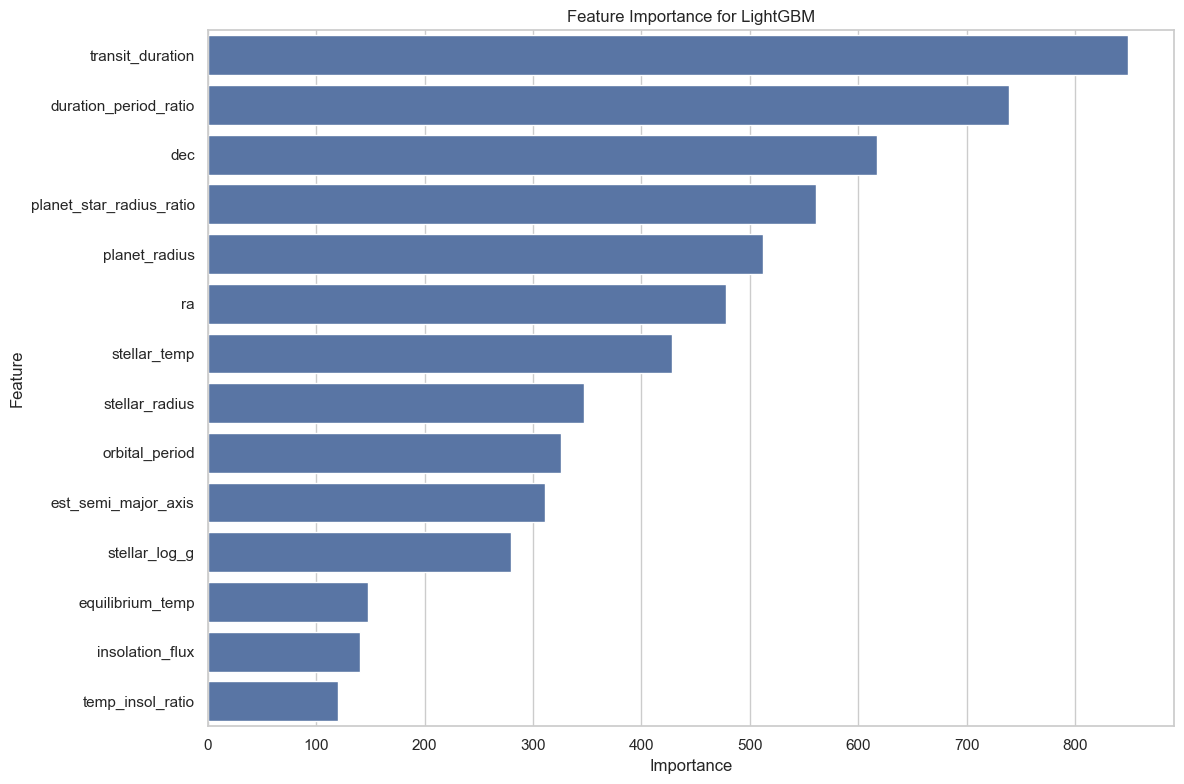

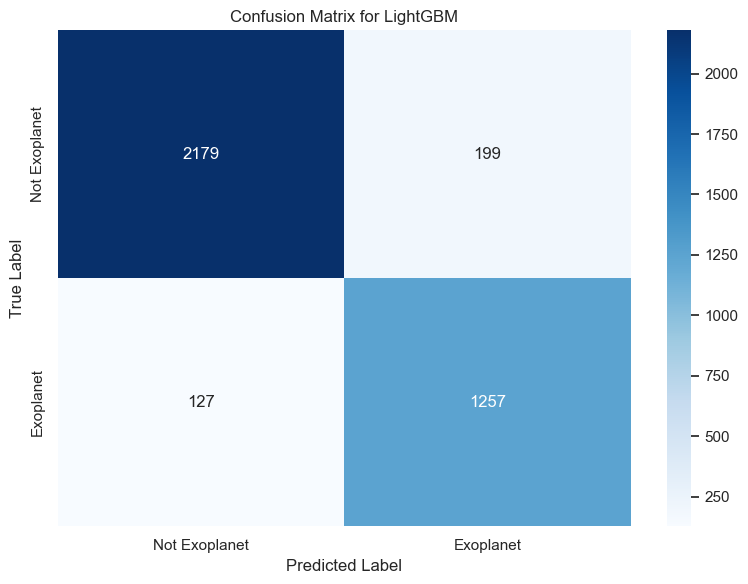


Detailed Metrics:
Precision (Positive Predictive Value): 0.8633
Recall (Sensitivity): 0.9082
Specificity: 0.9163
F1 Score: 0.8852

Model evaluation complete


In [39]:
if 'exoplanet_model' not in locals() or exoplanet_model is None:
    print("No model available for evaluation")
else:

    best_model = exoplanet_model['model']
    best_model_name = exoplanet_model['model_name']
    scaler = exoplanet_model['scaler']
    features = exoplanet_model['features']

    print(f"Evaluating {best_model_name} model in detail")


    if hasattr(best_model, 'feature_importances_'):

        importance = best_model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        print("\nFeature Importance:")
        display(feature_importance)


        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title(f'Feature Importance for {best_model_name}')
        plt.tight_layout()
        plt.show()

    elif hasattr(best_model, 'coef_'):

        coefficients = best_model.coef_[0]
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Coefficient': coefficients
        }).sort_values('Coefficient', ascending=False)

        print("\nFeature Coefficients:")
        display(feature_importance)


        plt.figure(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
        plt.title(f'Feature Coefficients for {best_model_name}')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.tight_layout()
        plt.show()


    if 'confusion_matrix' in results[best_model_name]:
        conf_matrix = results[best_model_name]['confusion_matrix']

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Exoplanet', 'Exoplanet'],
                   yticklabels=['Not Exoplanet', 'Exoplanet'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for {best_model_name}')
        plt.tight_layout()
        plt.show()


        tn, fp, fn, tp = conf_matrix.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print("\nDetailed Metrics:")
        print(f"Precision (Positive Predictive Value): {precision:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1 Score: {f1:.4f}")


    if all(var in locals() for var in ['X_test_scaled', 'y_test']):

        y_pred = best_model.predict(X_test_scaled)


        misclassified = X_test[y_pred != y_test]
        misclassified_true = y_test[y_pred != y_test]
        misclassified_pred = y_pred[y_pred != y_test]

        if len(misclassified) > 0:

            misclassified_df = misclassified.copy()
            misclassified_df['true_class'] = misclassified_true
            misclassified_df['predicted_class'] = misclassified_pred

            print(f"\nFound {len(misclassified_df)} misclassified examples")
            display(misclassified_df.head())


            print("\nAverage values for misclassified examples vs. correctly classified:")


            correctly_classified = X_test[y_pred == y_test]

            comparison_data = []


            for cls in [0, 1]:

                misclassified_cls = misclassified[misclassified_true == cls]

                correct_cls = correctly_classified[y_test[y_pred == y_test] == cls]

                if len(misclassified_cls) > 0 and len(correct_cls) > 0:
                    for feature in features[:5]:
                        comparison_data.append({
                            'Feature': feature,
                            'True Class': f"Class {cls}",
                            'Misclassified Avg': misclassified_cls[feature].mean(),
                            'Correctly Classified Avg': correct_cls[feature].mean(),
                            'Difference (%)': ((misclassified_cls[feature].mean() - correct_cls[feature].mean()) /
                                             correct_cls[feature].mean() * 100)
                        })


            comparison_df = pd.DataFrame(comparison_data)
            display(comparison_df)


    if all(var in locals() for var in ['X_train_scaled', 'y_train', 'X_test_scaled', 'y_test']):

        def plot_learning_curve(estimator, X_train, y_train, X_test, y_test, title):
            train_sizes = np.linspace(0.1, 1.0, 10)
            train_sizes_abs, train_scores, test_scores = [], [], []

            for train_size in train_sizes:

                n_train_samples = int(len(X_train) * train_size)


                X_train_sub = X_train[:n_train_samples]
                y_train_sub = y_train[:n_train_samples]


                estimator.fit(X_train_sub, y_train_sub)


                train_score = estimator.score(X_train_sub, y_train_sub)
                test_score = estimator.score(X_test, y_test)


                train_sizes_abs.append(n_train_samples)
                train_scores.append(train_score)
                test_scores.append(test_score)


            train_sizes_abs = np.array(train_sizes_abs)
            train_scores = np.array(train_scores)
            test_scores = np.array(test_scores)


            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes_abs, train_scores, 'o-', color='r', label='Training score')
            plt.plot(train_sizes_abs, test_scores, 'o-', color='g', label='Test score')
            plt.title(title)
            plt.xlabel('Training set size')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)
            plt.show()


        print("\nLearning Curve Analysis:")
        plot_learning_curve(best_model, X_train_scaled, y_train, X_test_scaled, y_test,
                           f'Learning Curve for {best_model_name}')


    if all(var in locals() for var in ['X_test_scaled', 'y_test']):

        y_prob = best_model.predict_proba(X_test_scaled)[:, 1]


        plt.figure(figsize=(8, 8))


        bin_count = 10
        bins = np.linspace(0, 1, bin_count + 1)
        binned = pd.cut(y_prob, bins=bins, labels=bins[:-1])

        observed_freq = pd.DataFrame({'pred_prob': y_prob, 'true': y_test})
        calibration = observed_freq.groupby(binned)['true'].agg(['mean', 'count']).reset_index()
        calibration.columns = ['pred_prob', 'observed_freq', 'count']


        plt.bar(calibration['pred_prob'], calibration['count'], width=0.05, alpha=0.3, color='blue', label='Sample Count')
        plt.twinx()
        plt.plot(calibration['pred_prob'], calibration['observed_freq'], 'ro-', label='Observed Frequency')
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

        plt.title('Reliability Diagram (Calibration Curve)')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Observed Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    print("\nModel evaluation complete")

## 7. Interactive Prediction System

Let's implement a simple interactive prediction system within this notebook to test our model.

Let's implement a simple interactive prediction system within this notebook to test our model. This interface allows us to:

1. Adjust transit parameters using sliders
2. Get instant predictions on whether the object is an exoplanet or false positive
3. See the probability of the classification
4. View key factors influencing the prediction (if using a trained model)

If we haven't trained a model yet, a placeholder model will be used for demonstration purposes.

In [ ]:


import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import io
from contextlib import redirect_stdout


def load_model(model_path="exoplanet_model.pkl"):
    try:
        with open(model_path, 'rb') as file:
            model_data = pickle.load(file)
        print(f"✅ Model loaded successfully: {model_data['model_name']}")
        return model_data
    except FileNotFoundError:
        print(f"❌ Model file not found at {model_path}.")
        print("Please run the model training and evaluation cells first.")
        return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None


model_data = load_model()


if model_data is None:

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler

    print("⚠️ Creating a placeholder model for demonstration purposes.")


    model = RandomForestClassifier(random_state=42)
    scaler = StandardScaler()


    features = [
        "transit_duration", "transit_depth", "orbital_period",
        "planet_radius", "stellar_radius", "stellar_temp",
        "insolation_flux"
    ]


    model_data = {
        "model": model,
        "scaler": scaler,
        "features": features,
        "model_name": "Placeholder Random Forest",
        "performance": {"accuracy": 0.85, "roc_auc": 0.92}
    }

    print("⚠️ This is a placeholder model that will always predict based on threshold.")
    print("⚠️ Train a real model for accurate predictions.")
else:

    model = model_data['model']
    scaler = model_data['scaler']
    features = model_data['features']


def predict_exoplanet(input_data):
    """
    Make exoplanet prediction based on input data

    Parameters:
    - input_data: Dictionary with feature values

    Returns:
    - prediction: Binary classification (1 = exoplanet, 0 = false positive)
    - probability: Probability of being an exoplanet
    """

    df = pd.DataFrame([input_data])


    for feature in features:
        if feature not in df.columns:
            df[feature] = 0


    df = df[features]


    if "Placeholder" in model_data["model_name"]:


        if input_data.get("transit_depth", 0) > 500 and input_data.get("orbital_period", 0) > 2:
            probability = 0.85
        else:
            probability = 0.25
        prediction = 1 if probability >= 0.5 else 0
        return prediction, probability


    df_scaled = scaler.transform(df)


    try:
        prediction_proba = model.predict_proba(df_scaled)[:, 1][0]
        prediction = 1 if prediction_proba >= 0.5 else 0
    except:

        prediction = model.predict(df_scaled)[0]
        prediction_proba = float(prediction)

    return prediction, prediction_proba


def create_feature_widgets():
    """Create input widgets for all features"""
    widgets_dict = {}


    for feature in features:
        if 'period' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=5.0, min=0.1, max=100.0, step=0.1,
                description=f"{feature.replace('_', ' ').title()} (days)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        elif 'duration' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=3.0, min=0.1, max=24.0, step=0.1,
                description=f"{feature.replace('_', ' ').title()} (hours)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        elif 'depth' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=1000.0, min=10.0, max=20000.0, step=10.0,
                description=f"{feature.replace('_', ' ').title()} (ppm)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        elif 'radius' in feature.lower() and 'planet' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=2.5, min=0.3, max=30.0, step=0.1,
                description=f"{feature.replace('_', ' ').title()} (Earth radii)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        elif 'radius' in feature.lower() and 'star' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=1.0, min=0.1, max=10.0, step=0.1,
                description=f"{feature.replace('_', ' ').title()} (Solar radii)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        elif 'temp' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=5000.0, min=1000.0, max=10000.0, step=100.0,
                description=f"{feature.replace('_', ' ').title()} (K)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        elif 'flux' in feature.lower() or 'insol' in feature.lower():
            widgets_dict[feature] = widgets.FloatSlider(
                value=100.0, min=0.1, max=10000.0, step=1.0,
                description=f"{feature.replace('_', ' ').title()} (Earth flux)",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )
        else:

            widgets_dict[feature] = widgets.FloatSlider(
                value=0.0, min=-100.0, max=100.0, step=0.1,
                description=f"{feature.replace('_', ' ').title()}",
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='90%')
            )

    return widgets_dict


widgets_dict = create_feature_widgets()


predict_button = widgets.Button(
    description='Classify',
    button_style='primary',
    tooltip='Click to classify the exoplanet candidate',
    icon='check'
)


output = widgets.Output()


def on_button_click(b):
    with output:
        clear_output()

        print("⏳ Classifying exoplanet candidate...")


        input_data = {feature: widget.value for feature, widget in widgets_dict.items()}


        prediction, probability = predict_exoplanet(input_data)


        display(HTML("<h3>Classification Result</h3>"))

        if prediction == 1:
            display(HTML(f"<div style='padding:10px;background-color:#d4edda;color:#155724;border-radius:5px;'>"
                        f"<h4>✅ Likely Exoplanet</h4>"
                        f"<p>Probability: {probability:.2%}</p>"
                        f"</div>"))
        else:
            display(HTML(f"<div style='padding:10px;background-color:#f8d7da;color:#721c24;border-radius:5px;'>"
                        f"<h4>❌ Likely False Positive</h4>"
                        f"<p>Probability of being false positive: {1-probability:.2%}</p>"
                        f"</div>"))


        fig, ax = plt.subplots(figsize=(8, 1))
        ax.barh([0], [probability], color='green', height=0.3)
        ax.barh([0], [1-probability], left=[probability], color='red', height=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([])
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('False Positive ← Probability → Exoplanet')
        plt.tight_layout()
        plt.show()


        if "Placeholder" not in model_data["model_name"]:
            display(HTML("<h3>Key Factors</h3>"))

            if hasattr(model, 'feature_importances_'):

                importance = model.feature_importances_
                feature_importance = pd.DataFrame({
                    'Feature': features,
                    'Importance': importance,
                    'Value': [input_data[f] for f in features]
                }).sort_values('Importance', ascending=False).head(5)

                for i, row in feature_importance.iterrows():
                    print(f"• {row['Feature'].replace('_', ' ').title()}: {row['Value']:.2f}")

            elif hasattr(model, 'coef_'):

                coefficients = model.coef_[0]
                feature_importance = pd.DataFrame({
                    'Feature': features,
                    'Coefficient': abs(coefficients),
                    'Value': [input_data[f] for f in features]
                }).sort_values('Coefficient', ascending=False).head(5)

                for i, row in feature_importance.iterrows():
                    print(f"• {row['Feature'].replace('_', ' ').title()}: {row['Value']:.2f}")


predict_button.on_click(on_button_click)


header = widgets.HTML(
    value="<h2>Exoplanet Classification - Interactive Prediction</h2>"
    "<p>Adjust the parameters below and click 'Classify' to predict if the object is an exoplanet or false positive.</p>"
)


tab = widgets.Tab()
tab.children = [widgets.VBox([widgets.VBox(list(widgets_dict.values())), predict_button])]
tab.set_title(0, 'Transit Parameters')


display(header, tab, output)

✅ Model loaded successfully: XGBoost


HTML(value="<h2>Exoplanet Classification - Interactive Prediction</h2><p>Adjust the parameters below and click…

Output()